# Exploratory Data Analysis on my LinkedIn connections, messages and more


In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import personal_linkedin_eda.utils.paths as path
import personal_linkedin_eda.utils.preprocess as prep
import personal_linkedin_eda.visualization.visualize as viz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

<IPython.core.display.Javascript object>

## Loading and formatting the data


In [4]:
%%capture
%run './1-cvillafraz-process-data.ipynb'
df_certifications = pd.read_parquet(path.data_processed_dir("certifications_clean.parquet"))
df_connections = pd.read_parquet(path.data_processed_dir("connections_clean.parquet"))
df_messages = pd.read_parquet(path.data_processed_dir("messages_clean.parquet"))
df_queries = pd.read_parquet(path.data_processed_dir("queries_clean.parquet"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cvillafraz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<IPython.core.display.Javascript object>

In [5]:
# Print every column name
print(f"Certifications columns: {df_certifications.columns}\n")
print(f"Connections columns: {df_connections.columns}\n")
print(f"Messages columns: {df_messages.columns}\n")
print(f"Queries columns: {df_queries.columns}")

Certifications columns: Index(['Name', 'Authority', 'Started On', 'Finished On'], dtype='object')

Connections columns: Index(['Company', 'Position', 'Connected On', 'Position Normalized'], dtype='object')

Messages columns: Index(['CONVERSATION TITLE', 'FROM', 'TO', 'DATE', 'SUBJECT', 'CONTENT'], dtype='object')

Queries columns: Index(['Time', 'Search Query'], dtype='object')


<IPython.core.display.Javascript object>

In [6]:
# Transform date string columns to datetime format
prep.to_datetime(df_certifications, "Started On", "Date Started", "%b %Y")
prep.to_datetime(df_connections, "Connected On", "Date Connected")
prep.to_datetime(df_messages, "DATE", "DATE")
prep.to_datetime(df_queries, "Time", "Time")

<IPython.core.display.Javascript object>

## Questions about certifications


### How many certifications have I completed and added to LinkedIn?


<AxesSubplot:title={'center':'Number of certifications by year of completion'}, xlabel='Year Started', ylabel='Number of certifications'>

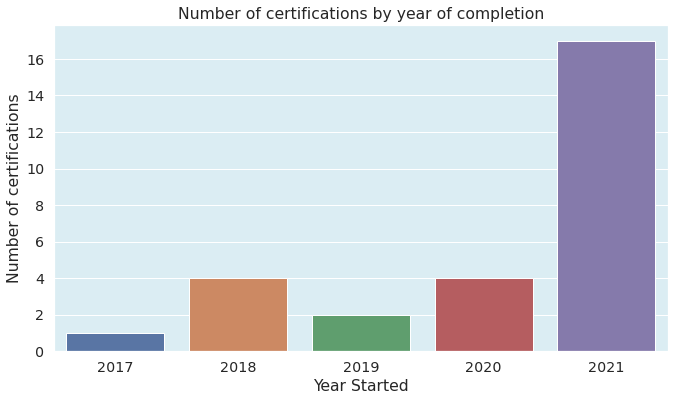

<IPython.core.display.Javascript object>

In [7]:
df_certifications["Year Started"] = df_certifications["Date Started"].dt.year
by_year = (
    df_certifications.sort_values("Year Started")
    .groupby("Year Started")["Year Started"]
    .count()
)
sns.set(rc={"figure.facecolor": "white", "axes.facecolor": "#dbedf3"}, font_scale=1.3)
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
ax.set(
    xlabel="Year of completion",
    ylabel="Number of certifications",
    title="Number of certifications by year of completion",
)
sns.barplot(x=by_year.index, y=by_year.values, ax=ax)

In 2021 I completed and added 4 times as many certifications as in 2018. This is due to the fact that I added most of my 2021 Platzi certifications to my LinkedIn profile


### Are there any certifications with an expiry date?


In [8]:
df_certifications[df_certifications["Finished On"].notna()]

,Name,Authority,Started On,Finished On,Date Started,Year Started
3,Google Analytics Individual Qualification,Google,May 2018,May 2019,2018-05-01,2018


<IPython.core.display.Javascript object>

I completed the Google Analytics IQ in 2018. I have to renew this certification


## Questions about connections


### What are the most common job positions in my network?


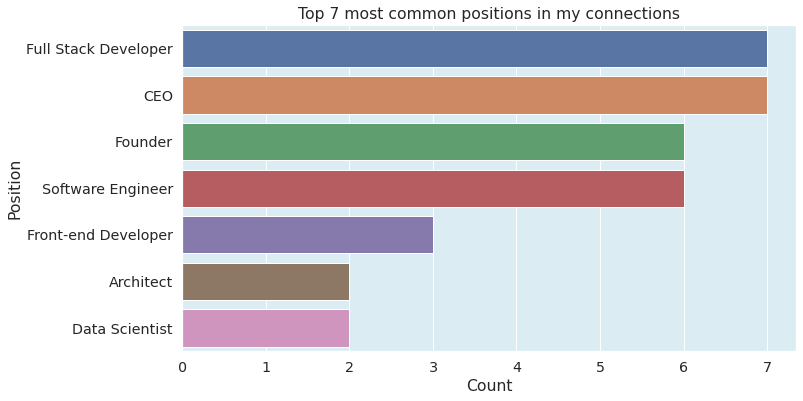

<IPython.core.display.Javascript object>

In [9]:
by_position = (
    df_connections.groupby("Position Normalized")["Position Normalized"]
    .count()
    .sort_values(ascending=False)
)
top_positions = by_position.head(7)
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
sns.barplot(x=top_positions.values, y=top_positions.index, ax=ax)
ax.set(
    xlabel="Count",
    ylabel="Position",
    title="Top 7 most common positions in my connections",
)
plt.show()

Not to my surprise, the most common positions are related to software engineering and management (CEO and founder). I have as many architects as data scientists in my network.


### How has my number of connections evolved through time?


In [10]:
def get_month_year(date_str):
    split_str = date_str.split(" ")
    return f"{split_str[1]} {split_str[2]}"


df_connections["Month_Year"] = df_connections["Connected On"].apply(get_month_year)
df_connections["Year"] = df_connections["Date Connected"].dt.year
df_connections["Month"] = df_connections["Date Connected"].dt.month

<IPython.core.display.Javascript object>

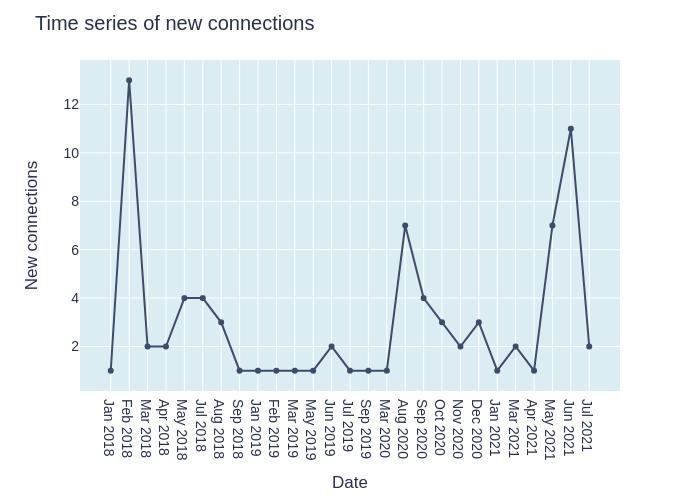

<IPython.core.display.Javascript object>

In [11]:
by_month_year = (
    df_connections.sort_values("Date Connected")
    .groupby(["Year", "Month", "Month_Year"])["Position"]
    .count()
    .reset_index()
)
fig = px.line(
    x=by_month_year["Month_Year"],
    y=by_month_year["Position"],
    color_discrete_sequence=["#404b69"],
    labels=dict(x="Date", y="New connections"),
    markers=True,
)
fig.update_layout(
    title="Time series of new connections",
    plot_bgcolor="#dbedf3",
    font_color="#283149",
    font_size=14
)
fig.show("png")

There are 3 main spikes in my number of new connections. In February 2018 is when I started adding more people to my network (mostly people who I have never interacted with, which is not recommended). In August 2020 is when I added most of my former coworkers at 321 Ignition (yes, I should have added them before). Finally, in June 2021 there was a personal brand challenge by Platzi called Say My Brand, which inspired me to add some new people from the Platzi community to my netwrok.


## Questions about messages


### What are the most common words in my conversations?


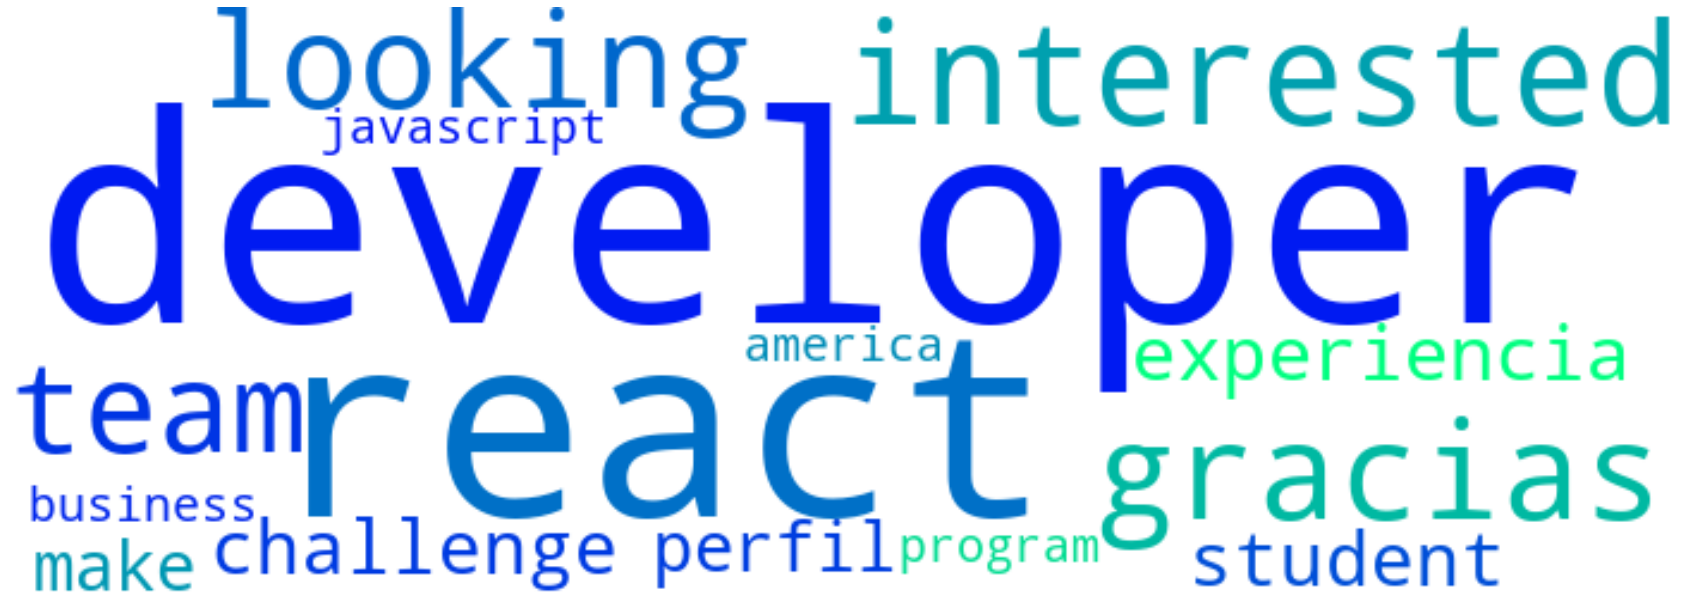

<IPython.core.display.Javascript object>

In [12]:
msg_text = " ".join(map(str, df_messages["CONTENT"].values))
viz.show_word_cloud(
    msg_text,
    height=250,
    stopwords=[
        "ciro",
        "hi",
        "hola",
        "bien",
        "ok",
        "si",
        "like",
        "would",
        "want",
        "puede",
        "linkedin",
    ],
)

Some of the most common words are developer, react, javascript, interested, etc. This has to do with the fact that several of my conversations are with recruiters looking for JS/React developers.


### What are the most common words in the subjects of my conversations?


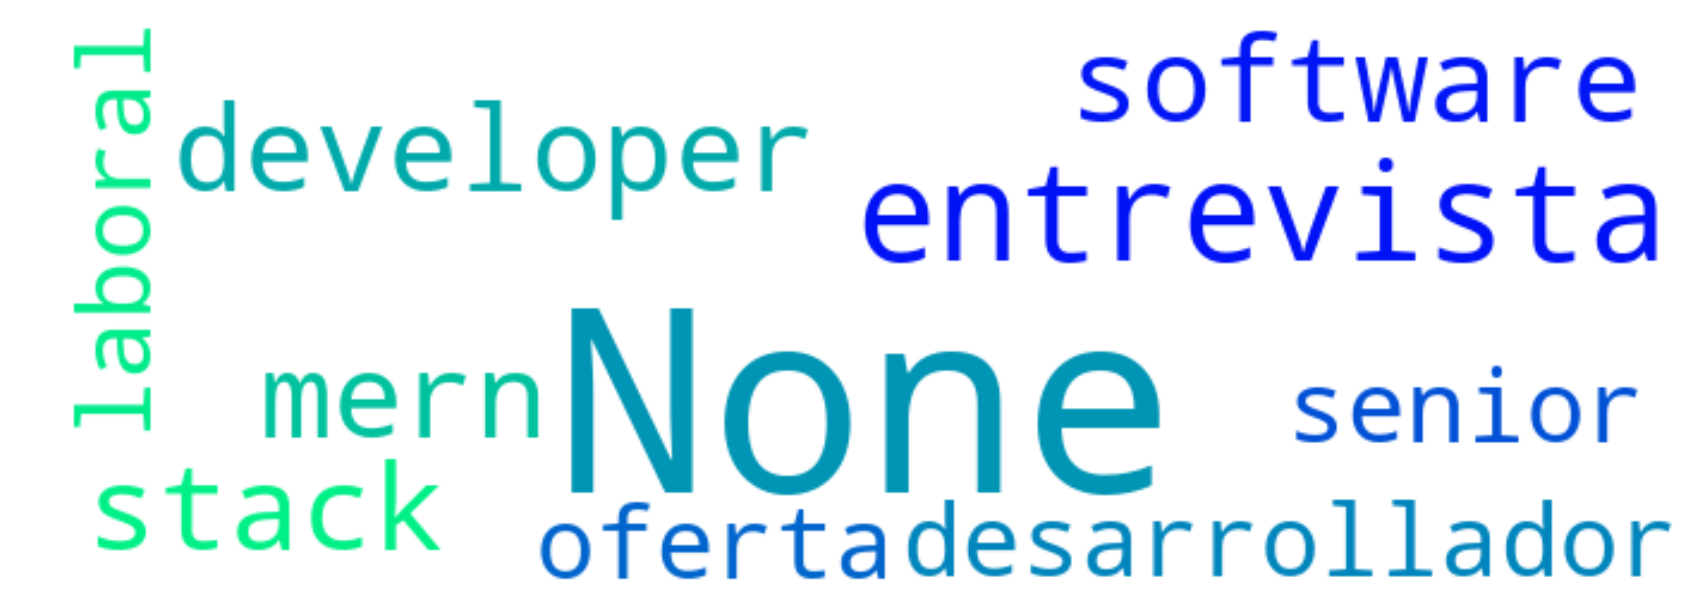

<IPython.core.display.Javascript object>

In [13]:
subject_text = " ".join(map(str, df_messages["SUBJECT"].values))
viz.show_word_cloud(
    subject_text, max_words=10, height=250, stopwords=["nan", "en", "edteam"]
)

Aside from words like developer and software, you can see "senior" there, which shows that several of the recruiters I have talked to were looking specifically for senior devs.


## Questions about my search queries


### What are the top 10 search queries made by me?


[Text(0.5, 1.0, 'Top 10 most searched terms by me')]

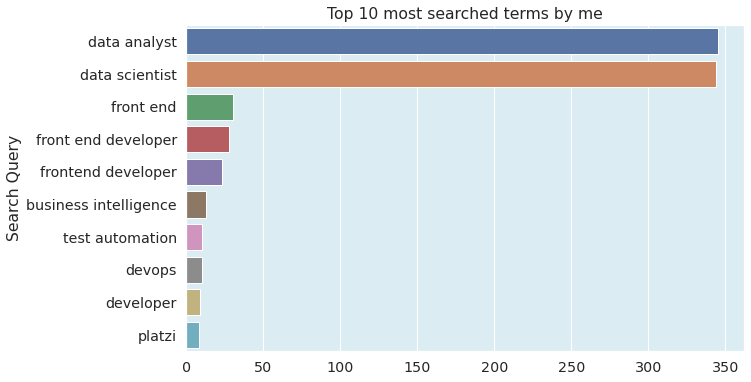

<IPython.core.display.Javascript object>

In [14]:
by_query = (
    df_queries.groupby("Search Query")["Search Query"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x=by_query.values, y=by_query.index, ax=ax)
ax.set(title="Top 10 most searched terms by me")

Although I was not surprised to see the terms data analyst/data scientist ahead of terms like "front end developer", I was shocked to see how much the terms data analyst/scientist are ahead. Especially considering that I have been interested in front-end jobs for 2 years more than data-related jobs. To find out what caused this result, I plotted a time series of my daily searches. I had the idea that maybe my search frequency had increased.


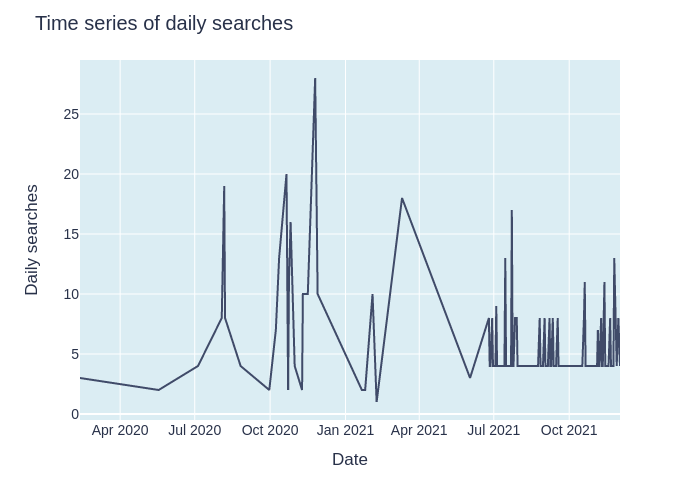

<IPython.core.display.Javascript object>

In [15]:
df_queries["Date"] = df_queries["Time"].dt.normalize()
by_time = df_queries.groupby("Date").count().reset_index()
fig = px.line(
    x=by_time["Date"],
    y=by_time["Time"],
    color_discrete_sequence=["#404b69"],
    labels=dict(x="Date", y="Daily searches"),
)
fig.update_layout(
    title="Time series of daily searches",
    plot_bgcolor="#dbedf3",
    font_color="#283149",
    font_size=14,
)
fig.show("png")

However, as you can see the search data starts from February 2020. This means that I have no way to access my LinkedIn search history from before that data.
